In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard imports
import os
import sys
sys.path.append("../")
sys.path.append("../../")
import math
import json
from typing import  List
from dataclasses import dataclass, field

import torch
import yaml
from src.utils.data_prep import (setup_dataloaders,)

import torch.nn as nn
import numpy as np
import pandas as pd
from src.methods.prediction_model import (SimpleNN)
from src.utils.train import (train_run)
from src.utils.io import (get_results_dir)
from sklearn.preprocessing import LabelEncoder
import src.utils.io as io   
from src.utils.functionalities import(
                                      set_seed)
import config as config
import src.utils.preprocess as preprocess
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from src.utils.plots import (multi_label_predictions)


In [3]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

In [4]:
print("Loading source data (Vectronics)...")
with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)
Vectronics_feature_cols = Vectronics_preprocessing_config['feature_cols']

min_duration_before_padding = 15.0
vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(min_duration_before_padding))
X_src = vectronics_df[Vectronics_feature_cols].values
y_src = vectronics_df['behavior'].values
label_encoder = LabelEncoder()
y_src = label_encoder.fit_transform(y_src)

print("Loading target data (RVC)...")
RVC_df = pd.read_csv(io.get_RVC_preprocessed_path())
X_targets = [RVC_df.loc[RVC_df.firmware_major_version == 2.0, Vectronics_feature_cols].values,
            RVC_df.loc[RVC_df.firmware_major_version == 3.0, Vectronics_feature_cols].values]


Loading source data (Vectronics)...
Loading target data (RVC)...


In [5]:
# --------------------------
# Step 1: Preprocess (compute quantiles using all domains)
# --------------------------
pos_idx = [0, 1, 2, 3, 4, 5]  # Indices of features that should be positive
center_idx = [6, 7, 8]  # Indices of features that should be centered at zero

# compute global lows/highs once
lows, highs = preprocess.compute_combined_quantiles(
    datasets=[X_src],
    pos_idx=pos_idx,
    center_idx=center_idx,
    low_q=0.00,
    high_q=1.00,
)

# define transform
transform = preprocess.TransformAndScale(
    pos_idx=pos_idx,
    center_idx=center_idx,
    lows=lows,
    highs=highs
)

X_src = transform(torch.tensor(X_src, dtype=torch.float32))
X_targets = [transform(torch.tensor(Xt, dtype=torch.float32)) for Xt in X_targets]

X_src = X_src.detach().numpy()
X_targets = [Xt.detach().numpy() for Xt in X_targets]

/tmp/ipykernel_1207735/367987444.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


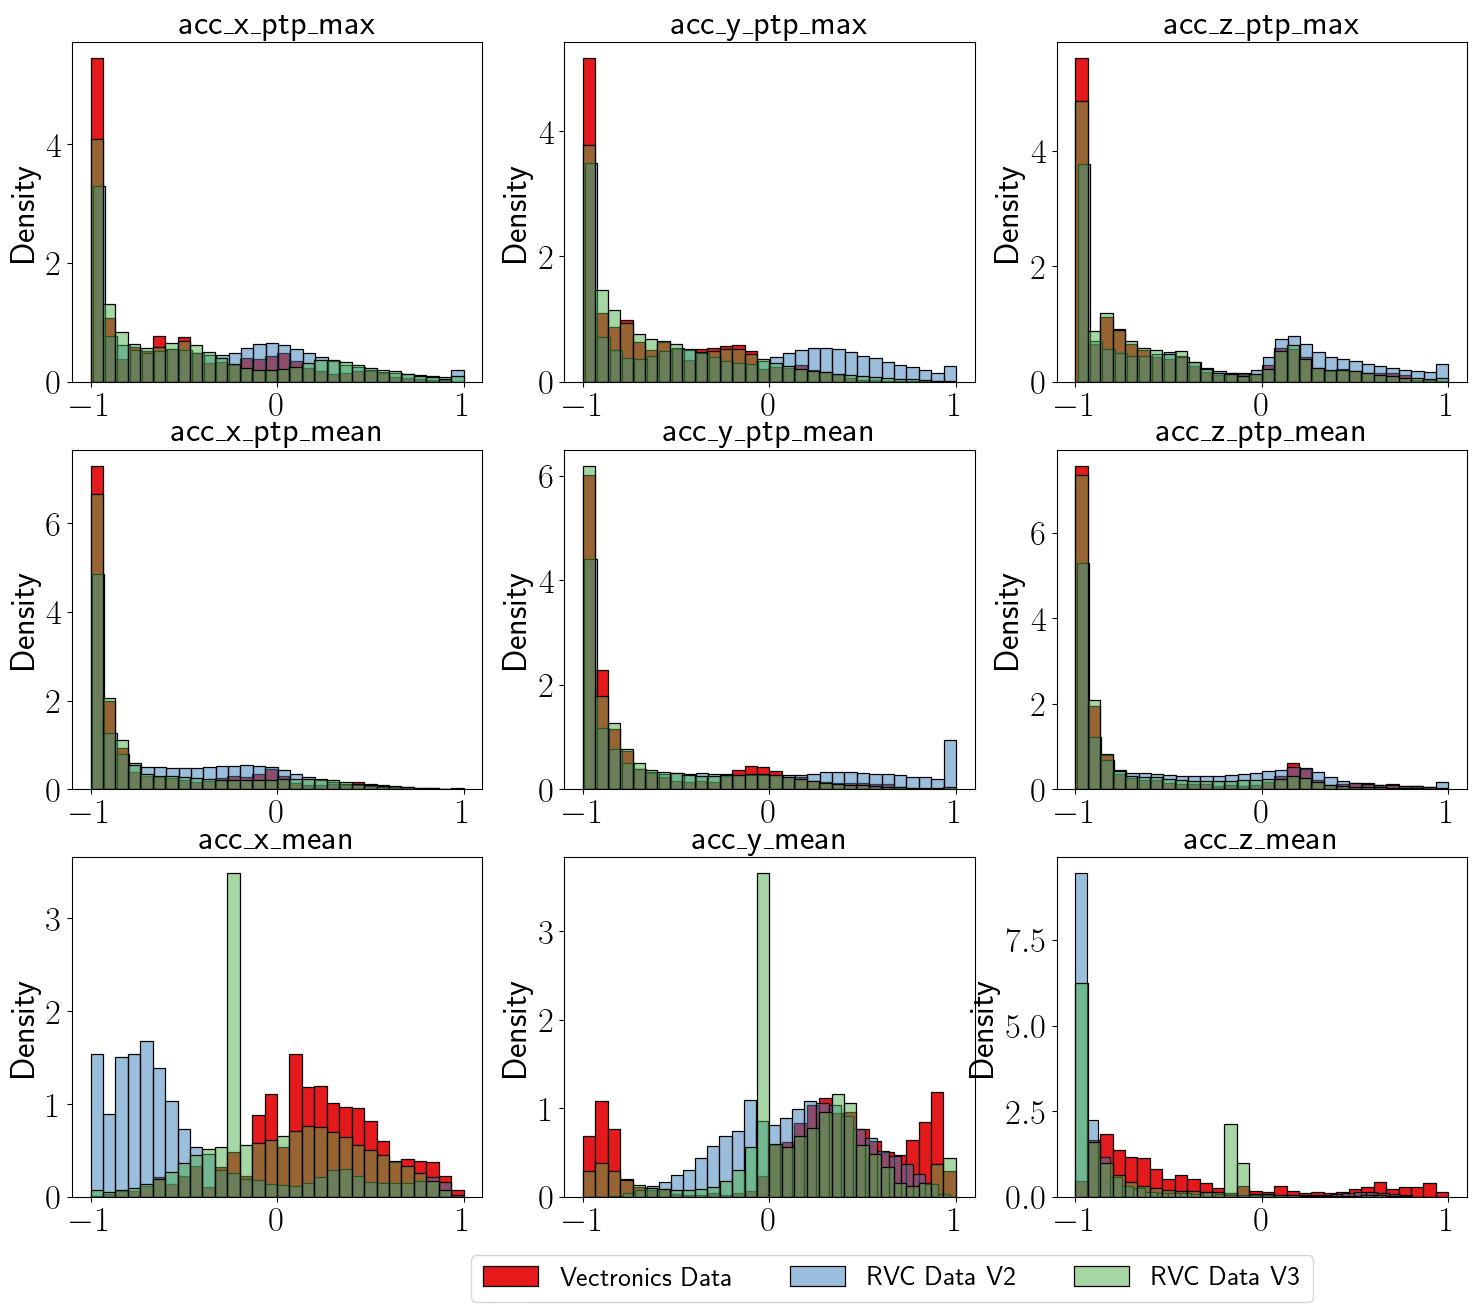

In [21]:
# Plot histograms of features
fig, axes = plt.subplots(len(Vectronics_feature_cols)//3, 3, figsize=(18, 5*(len(Vectronics_feature_cols)//3)))

palette = sns.color_palette("Set1", n_colors=3)
axes = axes.flatten()
for i, col in enumerate(Vectronics_feature_cols):
        ax = axes[i]

        sns.histplot(
                X_src[:,i],
                kde=False,
                label='Vectronics Data',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[0],
                alpha=1.0
            )

        sns.histplot(X_targets[0][:,i],
                kde=False,
                label='RVC Data V2',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[1],
                alpha=0.5
            )
        sns.histplot(X_targets[1][:,i],
                kde=False,
                label='RVC Data V3',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[2],
                alpha=0.5
            )
    
        ax.set_title(col)
        ax.set_ylabel('Density')
        # ax.set_yscale("log")
        ax.set_xlabel('')

# Get legend info from the first axes
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='lower center', bbox_to_anchor=(2.0, -2.75), ncol=3)

plt.tight_layout()
plt.show()


In [6]:
def _covariance(X, rowvar=False):
    # rowvar=False: rows are samples, columns are features
    if rowvar:
        X = X.T
    n = X.shape[0]
    # unbiased estimator (n-1)
    mean = np.mean(X, axis=0, keepdims=True)
    Xc = X - mean
    cov = (Xc.T @ Xc) / (n - 1)
    return cov, mean.squeeze()

def _matrix_sqrt(mat):
    # mat is symmetric positive definite (or semidef). compute sqrt via SVD/eig.
    # Use eigen decomposition for symmetric mats
    s, U = np.linalg.eigh(mat)
    # clamp small negatives to zero, stable sqrt
    s_clamped = np.clip(s, a_min=0.0, a_max=None)
    sqrt_s = np.sqrt(s_clamped)
    sqrt_mat = (U * sqrt_s) @ U.T
    return sqrt_mat

def _matrix_inv_sqrt(mat, eps=1e-10):
    s, U = np.linalg.eigh(mat)
    s_clamped = np.clip(s, a_min=0.0, a_max=None)
    inv_sqrt_s = 1.0 / (np.sqrt(s_clamped) + eps)
    inv_sqrt = (U * inv_sqrt_s) @ U.T
    return inv_sqrt

def coral_transform(Xs, Xt, eps=1e-6, return_transform=False):
    """
    Align covariance of Xs to covariance of Xt using CORAL.
    Returns transformed Xs.
    """
    Xs = np.asarray(Xs, dtype=float)
    Xt = np.asarray(Xt, dtype=float)
    assert Xs.ndim == 2 and Xt.ndim == 2
    n_s, d = Xs.shape
    n_t, d2 = Xt.shape
    assert d == d2, "Feature dims must match"
    # compute covariances and means
    Cs, mean_s = _covariance(Xs, rowvar=False)
    Ct, mean_t = _covariance(Xt, rowvar=False)
    # regularize
    Cs_reg = Cs + eps * np.eye(d)
    Ct_reg = Ct + eps * np.eye(d)
    # compute inverse sqrt(Cs) and sqrt(Ct)
    Cs_inv_sqrt = _matrix_inv_sqrt(Cs_reg, eps=eps)
    Ct_sqrt = _matrix_sqrt(Ct_reg)
    # transform centered Xs
    Xs_centered = Xs - mean_s
    A = Cs_inv_sqrt @ Ct_sqrt
    Xs_aligned = (Xs_centered @ A) + mean_t  # recolor and shift mean to target mean
    if return_transform:
        return Xs_aligned, {'A': A, 'mean_s': mean_s, 'mean_t': mean_t}
    else:
        return Xs_aligned

In [7]:
X_src_aligned1 = coral_transform(X_src, X_targets[0], eps=1e-6, return_transform=False)
X_src_aligned2 = coral_transform(X_src, X_targets[1], eps=1e-6, return_transform=False)


/tmp/ipykernel_1207735/3061896543.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


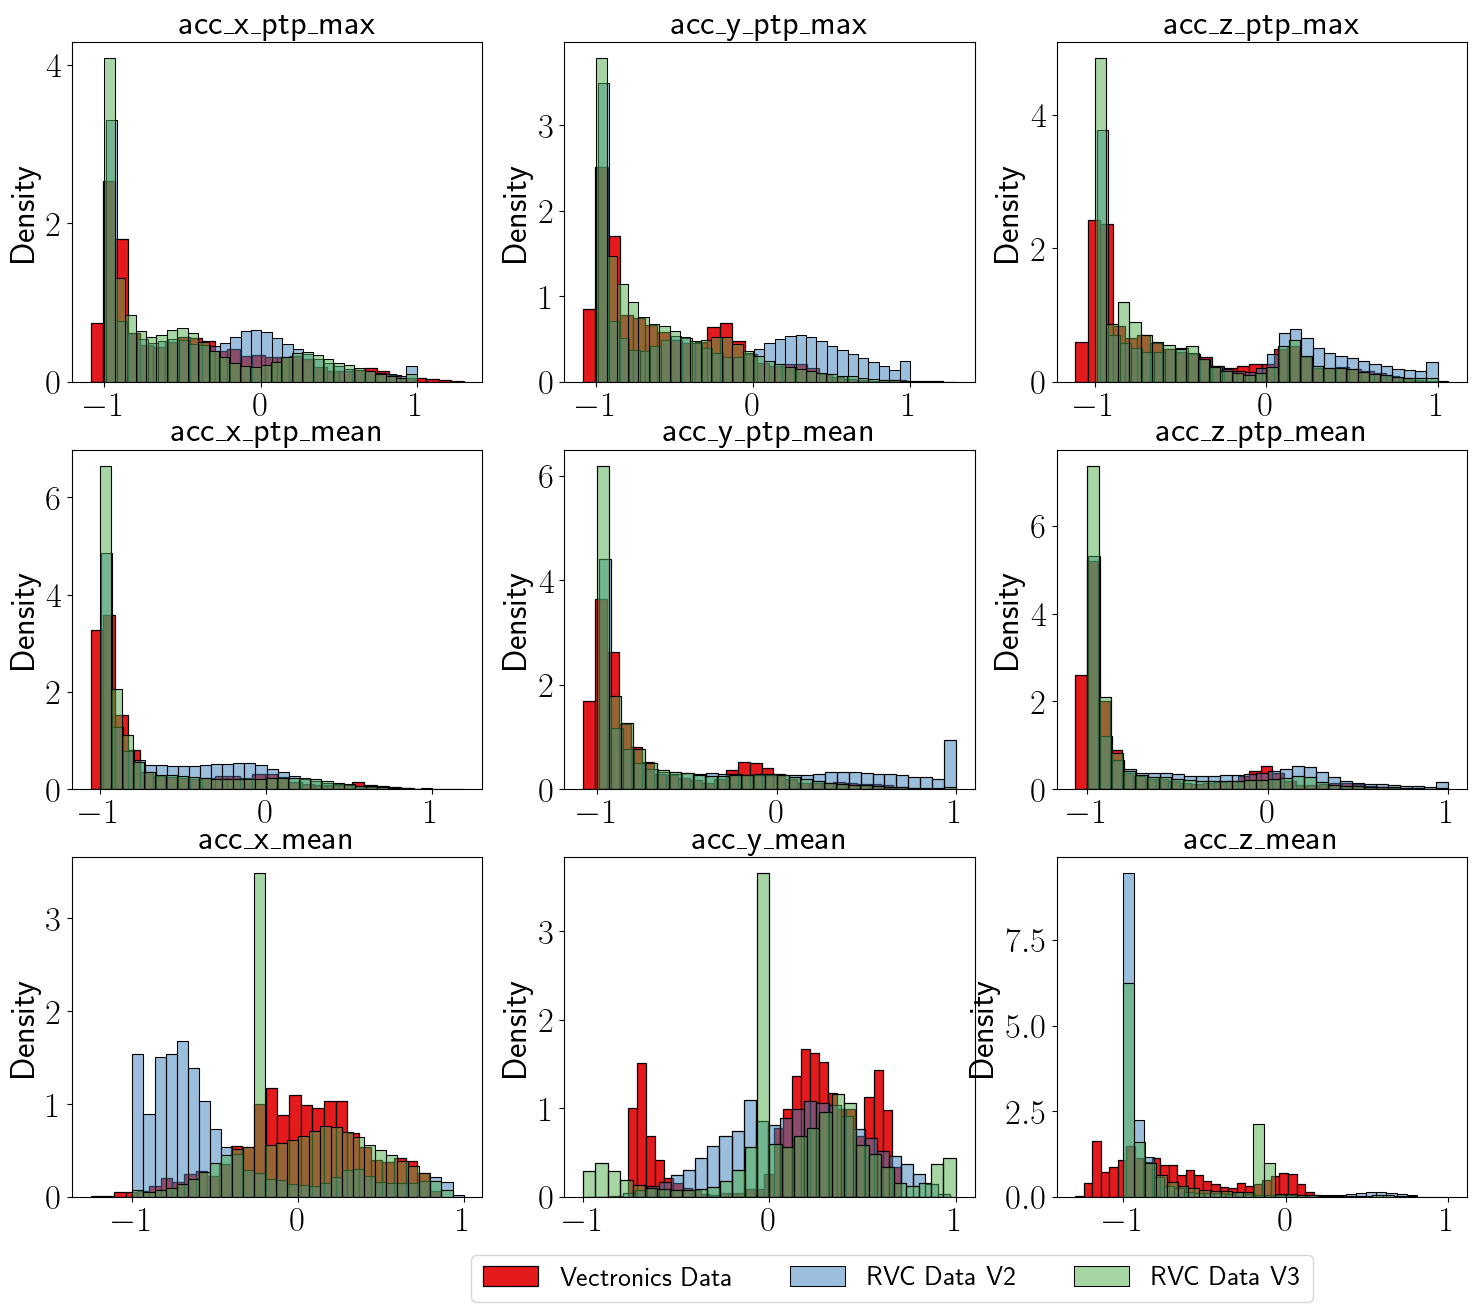

In [ ]:
# Plot histograms of features
fig, axes = plt.subplots(len(Vectronics_feature_cols)//3, 3, figsize=(18, 5*(len(Vectronics_feature_cols)//3)))

palette = sns.color_palette("Set1", n_colors=3)
axes = axes.flatten()
for i, col in enumerate(Vectronics_feature_cols):
        ax = axes[i]

        sns.histplot(
                X_src_aligned1[:,i],
                kde=False,
                label='Vectronics Data',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[0],
                alpha=1.0
            )

        sns.histplot(X_targets[0][:,i],
                kde=False,
                label='RVC Data V2',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[1],
                alpha=0.5
            )
        sns.histplot(X_targets[1][:,i],
                kde=False,
                label='RVC Data V3',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[2],
                alpha=0.5
            )
    
        ax.set_title(col)
        ax.set_ylabel('Density')
        ax.set_xlabel('')

# Get legend info from the first axes
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='lower center', bbox_to_anchor=(2.0, -2.75), ncol=3)

plt.tight_layout()
plt.show()


In [8]:
# train and model arguments

@dataclass
class TrainArgs:
    batch_size: int = 512
    num_epochs: int = 100
    theta: float = 0.5
    learning_rate: float = 0.001
    weight_decay: float = 0.0001
    print_freq: int = 10
    verbose: bool = False
    seed: int= 1

@dataclass
class ModelArgs:
    hidden_layers: List[int] = field(default_factory=lambda: [32, 64])
    dropout_rate: float = 0.5

train_args = TrainArgs()
model_args = ModelArgs()

In [9]:
theta_list = np.round(0.1 * np.arange(11), 1)
seed_list = [1]
training_results_dir = os.path.join(get_results_dir(), 'results/domain_adaptation_training_results', 'shallow_coral')
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

X_train, X_temp, y_train, y_temp = train_test_split(X_src_aligned1, y_src, test_size=0.4, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

for theta in tqdm(theta_list, desc="Training models for different theta values"):
    for seed in seed_list:

        tqdm.write(f"Current theta: {theta}, Current seed: {seed}")
        train_args.theta = theta
        train_args.seed = seed

        set_seed(seed)

        # setup dataloaders
        train_dataloader, val_dataloader, test_dataloader = setup_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_args)

        # setup model, loss, and optimizer
        model = SimpleNN(input_dim=X_train.shape[1], n_ouputs=len(config.SUMMARY_BEHAVIORS), hidden_layers=model_args.hidden_layers, dropout_rate=model_args.dropout_rate).to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=train_args.learning_rate, weight_decay=train_args.weight_decay)

        #### Training
        train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, train_args, device)
        model = train_obj['model'].to(device)
        training_stats = train_obj['training_stats']

        model_dir = os.path.join(training_results_dir, f"theta{train_args.theta}_seed{train_args.seed}")
        os.makedirs(model_dir, exist_ok=True)

        torch.save(model, os.path.join(model_dir, 'model.pt'))
        json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
        with open(json_training_stats_file, 'w') as f:
            json.dump(training_stats, f)

        # save true and predicted validation classes along with val metadata
        np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
        np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])
        np.save(os.path.join(model_dir, 'val_scores.npy'),  train_obj['val_scores'])

        # save true and predicted validation classes along with val metadata
        np.save(os.path.join(model_dir, 'test_true_classes.npy'),  train_obj['test_true_classes'])
        np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])
        np.save(os.path.join(model_dir, 'test_scores.npy'),  train_obj['test_scores'])
        

X_train: (5459, 9) y_train: (5459,)
X_val: (1820, 9) y_val: (1820,)
X_test: (1820, 9) y_test: (1820,)


Training models for different theta values:   0%|          | 0/11 [00:00<?, ?it/s]

Current theta: 0.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.0486 | Val Loss: 0.0368 | Best val Loss: 0.0368: 100%|██████████| 100/100 [00:07<00:00, 14.11it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:07<01:19,  7.97s/it]

Total training time: 0:00:07
Current theta: 0.1, Current seed: 1


Epoch 100/100 | Train Loss: 0.0723 | Val Loss: 0.0361 | Best val Loss: 0.0361: 100%|██████████| 100/100 [00:06<00:00, 14.62it/s]
Training models for different theta values:  18%|█▊        | 2/11 [00:14<01:05,  7.32s/it]

Total training time: 0:00:07
Current theta: 0.2, Current seed: 1


Epoch 100/100 | Train Loss: 0.0895 | Val Loss: 0.0367 | Best val Loss: 0.0367: 100%|██████████| 100/100 [00:06<00:00, 14.44it/s]
Training models for different theta values:  27%|██▋       | 3/11 [00:21<00:57,  7.14s/it]

Total training time: 0:00:07
Current theta: 0.3, Current seed: 1


Epoch 100/100 | Train Loss: 0.1030 | Val Loss: 0.0386 | Best val Loss: 0.0379: 100%|██████████| 100/100 [00:06<00:00, 14.67it/s]
Training models for different theta values:  36%|███▋      | 4/11 [00:28<00:49,  7.02s/it]

Total training time: 0:00:07
Current theta: 0.4, Current seed: 1


Epoch 100/100 | Train Loss: 0.1091 | Val Loss: 0.0374 | Best val Loss: 0.0374: 100%|██████████| 100/100 [00:07<00:00, 14.12it/s]
Training models for different theta values:  45%|████▌     | 5/11 [00:35<00:42,  7.05s/it]

Total training time: 0:00:07
Current theta: 0.5, Current seed: 1


Epoch 100/100 | Train Loss: 0.1159 | Val Loss: 0.0399 | Best val Loss: 0.0391: 100%|██████████| 100/100 [00:06<00:00, 15.15it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [00:42<00:34,  6.90s/it]

Total training time: 0:00:07
Current theta: 0.6, Current seed: 1


Epoch 100/100 | Train Loss: 0.1248 | Val Loss: 0.0409 | Best val Loss: 0.0409: 100%|██████████| 100/100 [00:06<00:00, 14.94it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [00:49<00:27,  6.84s/it]

Total training time: 0:00:07
Current theta: 0.7, Current seed: 1


Epoch 100/100 | Train Loss: 0.1329 | Val Loss: 0.0432 | Best val Loss: 0.0432: 100%|██████████| 100/100 [00:06<00:00, 15.37it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [00:55<00:20,  6.74s/it]

Total training time: 0:00:07
Current theta: 0.8, Current seed: 1


Epoch 100/100 | Train Loss: 0.1369 | Val Loss: 0.0498 | Best val Loss: 0.0460: 100%|██████████| 100/100 [00:06<00:00, 15.46it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [01:02<00:13,  6.66s/it]

Total training time: 0:00:06
Current theta: 0.9, Current seed: 1


Epoch 100/100 | Train Loss: 0.1430 | Val Loss: 0.0545 | Best val Loss: 0.0517: 100%|██████████| 100/100 [00:06<00:00, 15.68it/s]
Training models for different theta values:  91%|█████████ | 10/11 [01:08<00:06,  6.58s/it]

Total training time: 0:00:06
Current theta: 1.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.1390 | Val Loss: 0.0645 | Best val Loss: 0.0593: 100%|██████████| 100/100 [00:06<00:00, 15.38it/s]
Training models for different theta values: 100%|██████████| 11/11 [01:14<00:00,  6.81s/it]

Total training time: 0:00:07


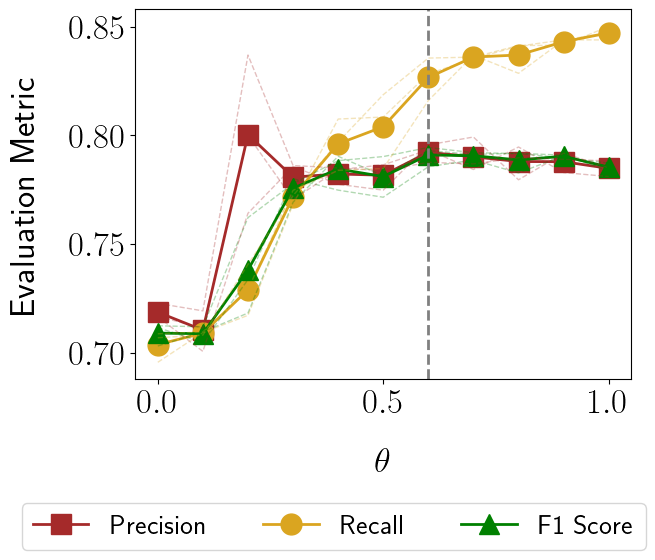

In [10]:
colors = ['brown', 'goldenrod', 'green']

precisions, recalls, f1scores = np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list)))

for j, theta in enumerate(theta_list):
    for k, seed in enumerate(seed_list):

        model_dir = os.path.join(training_results_dir, f"theta{theta}_seed{seed}")
        precisions[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
        recalls[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
        f1scores[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

plt.plot(theta_list, np.mean(precisions, axis=-1), color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(theta_list, np.mean(recalls, axis=-1), color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(theta_list, np.mean(f1scores, axis=-1), color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)

for k in range(len(seed_list)):
    plt.plot(theta_list, precisions[:,k], color=colors[0], linewidth=1, linestyle='--', alpha=0.3)
    plt.plot(theta_list, recalls[:,k], color=colors[1],  linewidth=1, linestyle='--', alpha=0.3)
    plt.plot(theta_list, f1scores[:,k], color=colors[2], linewidth=1, linestyle='--', alpha=0.3)

plt.axvline(x=theta_list[np.argmax(np.mean(f1scores, axis=-1))], linestyle='--', color='grey', linewidth=2,)
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)

plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.4,-0.5))
plt.show()  

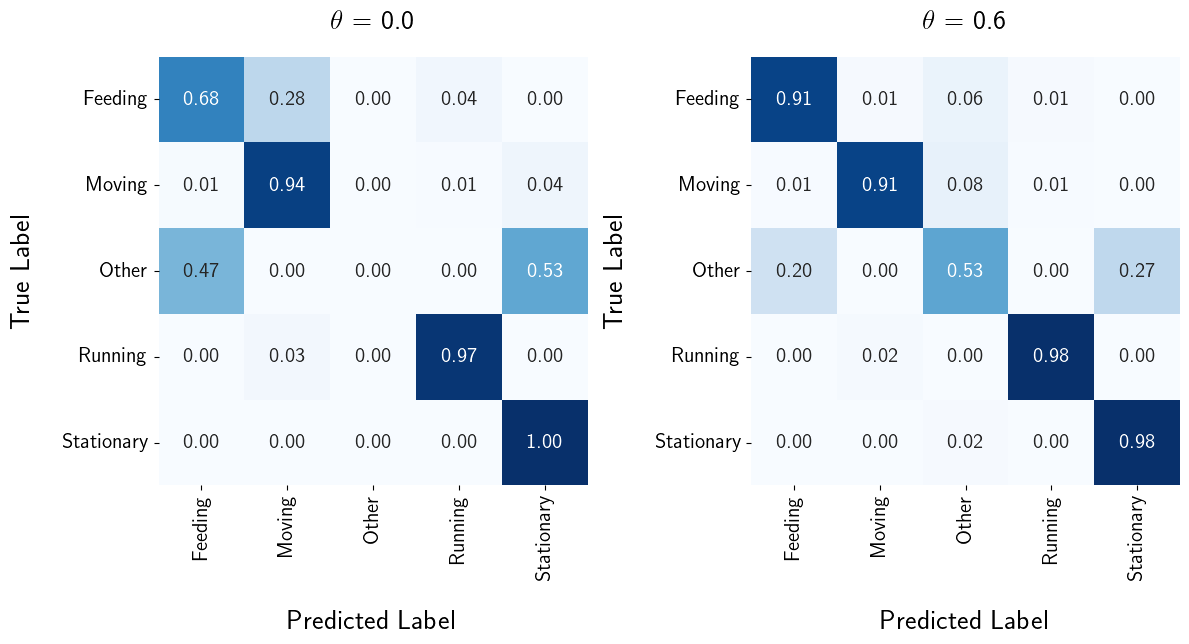

In [10]:
theta_list = [0.0, 0.6]
seed_star = 1
fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 8))

for i, theta in enumerate(theta_list):

    ax = axs[i]

    model_dir = os.path.join(training_results_dir, f"theta{theta}_seed{seed_star}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')
    class_names = label_encoder.inverse_transform(np.arange(len(np.unique(val_true))))

    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, square=True, linewidths=0,
                annot_kws={"size": 15}, ax=ax)

    ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
    ax.set_ylabel("True Label", fontsize=20, labelpad=20)
    ax.set_xticklabels(class_names, fontsize=15, rotation=90)
    ax.set_yticklabels(class_names, fontsize=15, rotation=0)
    ax.set_title(f"$\\theta$ = {theta}", fontsize=20, pad=20)


plt.tight_layout()
plt.show()

In [11]:
with torch.no_grad():
    yt = model(torch.tensor(X_targets[0], dtype=torch.float32).to(device))

yt = yt.cpu().numpy()
yt = np.argmax(yt, axis=1)

print("RVC V2 PREDICTED CLASS DISTRIBUTION")
unique, counts = np.unique(yt, return_counts=True)
proportions = counts / len(yt)

for cls_int, prop in zip(unique, proportions):
    print(f"{label_encoder.inverse_transform([cls_int])[0]}: {prop:.2%}")

RVC V2 PREDICTED CLASS DISTRIBUTION
Feeding: 7.27%
Moving: 14.91%
Other: 14.55%
Running: 4.43%
Stationary: 58.85%


In [12]:
theta_list = np.round(0.1 * np.arange(11), 1)
seed_list = [1]
training_results_dir = os.path.join(get_results_dir(), 'results/domain_adaptation_training_results', 'shallow_coral')
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

X_train, X_temp, y_train, y_temp = train_test_split(X_src_aligned2, y_src, test_size=0.4, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

for theta in tqdm(theta_list, desc="Training models for different theta values"):
    for seed in seed_list:

        tqdm.write(f"Current theta: {theta}, Current seed: {seed}")
        train_args.theta = theta
        train_args.seed = seed

        set_seed(seed)

        # setup dataloaders
        train_dataloader, val_dataloader, test_dataloader = setup_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_args)

        # setup model, loss, and optimizer
        model = SimpleNN(input_dim=X_train.shape[1], n_ouputs=len(config.SUMMARY_BEHAVIORS), hidden_layers=model_args.hidden_layers, dropout_rate=model_args.dropout_rate).to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=train_args.learning_rate, weight_decay=train_args.weight_decay)

        #### Training
        train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, train_args, device)
        model = train_obj['model'].to(device)
        training_stats = train_obj['training_stats']

        model_dir = os.path.join(training_results_dir, f"theta{train_args.theta}_seed{train_args.seed}")
        os.makedirs(model_dir, exist_ok=True)

        torch.save(model, os.path.join(model_dir, 'model.pt'))
        json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
        with open(json_training_stats_file, 'w') as f:
            json.dump(training_stats, f)

        # save true and predicted validation classes along with val metadata
        np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
        np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])
        np.save(os.path.join(model_dir, 'val_scores.npy'),  train_obj['val_scores'])

        # save true and predicted validation classes along with val metadata
        np.save(os.path.join(model_dir, 'test_true_classes.npy'),  train_obj['test_true_classes'])
        np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])
        np.save(os.path.join(model_dir, 'test_scores.npy'),  train_obj['test_scores'])
        

X_train: (5459, 9) y_train: (5459,)
X_val: (1820, 9) y_val: (1820,)
X_test: (1820, 9) y_test: (1820,)


Training models for different theta values:   0%|          | 0/11 [00:00<?, ?it/s]

Current theta: 0.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.0483 | Val Loss: 0.0357 | Best val Loss: 0.0357: 100%|██████████| 100/100 [00:06<00:00, 14.38it/s]
Training models for different theta values:   9%|▉         | 1/11 [00:06<01:09,  6.98s/it]

Total training time: 0:00:07
Current theta: 0.1, Current seed: 1


Epoch 100/100 | Train Loss: 0.0725 | Val Loss: 0.0350 | Best val Loss: 0.0350: 100%|██████████| 100/100 [00:06<00:00, 14.71it/s]
Training models for different theta values:  18%|█▊        | 2/11 [00:13<01:01,  6.88s/it]

Total training time: 0:00:07
Current theta: 0.2, Current seed: 1


Epoch 100/100 | Train Loss: 0.0863 | Val Loss: 0.0354 | Best val Loss: 0.0354: 100%|██████████| 100/100 [00:06<00:00, 14.82it/s]
Training models for different theta values:  27%|██▋       | 3/11 [00:20<00:54,  6.83s/it]

Total training time: 0:00:07
Current theta: 0.3, Current seed: 1


Epoch 100/100 | Train Loss: 0.0928 | Val Loss: 0.0353 | Best val Loss: 0.0344: 100%|██████████| 100/100 [00:06<00:00, 14.72it/s]
Training models for different theta values:  36%|███▋      | 4/11 [00:27<00:47,  6.82s/it]

Total training time: 0:00:07
Current theta: 0.4, Current seed: 1


Epoch 100/100 | Train Loss: 0.1095 | Val Loss: 0.0360 | Best val Loss: 0.0360: 100%|██████████| 100/100 [00:06<00:00, 14.52it/s]
Training models for different theta values:  45%|████▌     | 5/11 [00:34<00:41,  6.85s/it]

Total training time: 0:00:07
Current theta: 0.5, Current seed: 1


Epoch 100/100 | Train Loss: 0.1169 | Val Loss: 0.0390 | Best val Loss: 0.0361: 100%|██████████| 100/100 [00:06<00:00, 15.55it/s]
Training models for different theta values:  55%|█████▍    | 6/11 [00:40<00:33,  6.71s/it]

Total training time: 0:00:06
Current theta: 0.6, Current seed: 1


Epoch 100/100 | Train Loss: 0.1229 | Val Loss: 0.0411 | Best val Loss: 0.0385: 100%|██████████| 100/100 [00:06<00:00, 15.51it/s]
Training models for different theta values:  64%|██████▎   | 7/11 [00:47<00:26,  6.63s/it]

Total training time: 0:00:06
Current theta: 0.7, Current seed: 1


Epoch 100/100 | Train Loss: 0.1314 | Val Loss: 0.0450 | Best val Loss: 0.0421: 100%|██████████| 100/100 [00:06<00:00, 15.56it/s]
Training models for different theta values:  73%|███████▎  | 8/11 [00:53<00:19,  6.57s/it]

Total training time: 0:00:06
Current theta: 0.8, Current seed: 1


Epoch 100/100 | Train Loss: 0.1343 | Val Loss: 0.0493 | Best val Loss: 0.0451: 100%|██████████| 100/100 [00:06<00:00, 15.74it/s]
Training models for different theta values:  82%|████████▏ | 9/11 [00:59<00:13,  6.51s/it]

Total training time: 0:00:06
Current theta: 0.9, Current seed: 1


Epoch 100/100 | Train Loss: 0.1363 | Val Loss: 0.0539 | Best val Loss: 0.0495: 100%|██████████| 100/100 [00:06<00:00, 15.26it/s]
Training models for different theta values:  91%|█████████ | 10/11 [01:06<00:06,  6.53s/it]

Total training time: 0:00:07
Current theta: 1.0, Current seed: 1


Epoch 100/100 | Train Loss: 0.1396 | Val Loss: 0.0631 | Best val Loss: 0.0591: 100%|██████████| 100/100 [00:07<00:00, 12.96it/s]
Training models for different theta values: 100%|██████████| 11/11 [01:14<00:00,  6.75s/it]

Total training time: 0:00:08


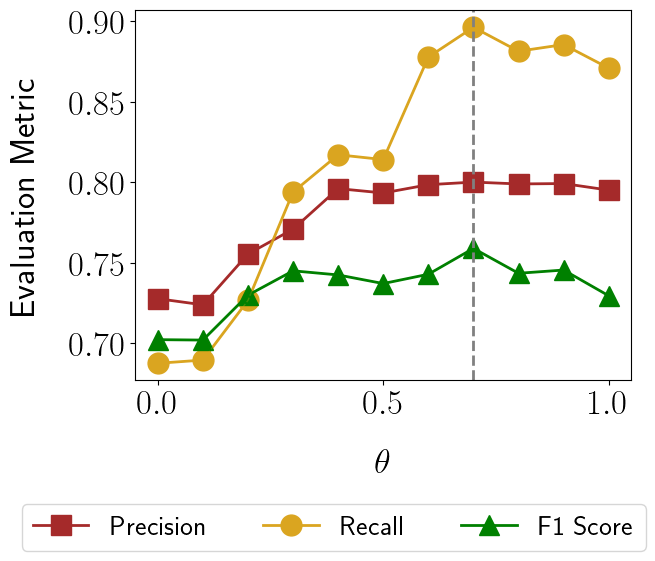

In [13]:
colors = ['brown', 'goldenrod', 'green']

precisions, recalls, f1scores = np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list))), np.zeros((len(theta_list), len(seed_list)))

for j, theta in enumerate(theta_list):
    for k, seed in enumerate(seed_list):

        model_dir = os.path.join(training_results_dir, f"theta{theta}_seed{seed}")
        precisions[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
        recalls[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
        f1scores[j,k] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

plt.plot(theta_list, np.mean(precisions, axis=-1), color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(theta_list, np.mean(recalls, axis=-1), color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(theta_list, np.mean(f1scores, axis=-1), color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)

for k in range(len(seed_list)):
    plt.plot(theta_list, precisions[:,k], color=colors[0], linewidth=1, linestyle='--', alpha=0.3)
    plt.plot(theta_list, recalls[:,k], color=colors[1],  linewidth=1, linestyle='--', alpha=0.3)
    plt.plot(theta_list, f1scores[:,k], color=colors[2], linewidth=1, linestyle='--', alpha=0.3)

plt.axvline(x=theta_list[np.argmax(np.mean(f1scores, axis=-1))], linestyle='--', color='grey', linewidth=2,)
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)

plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.4,-0.5))
plt.show()  

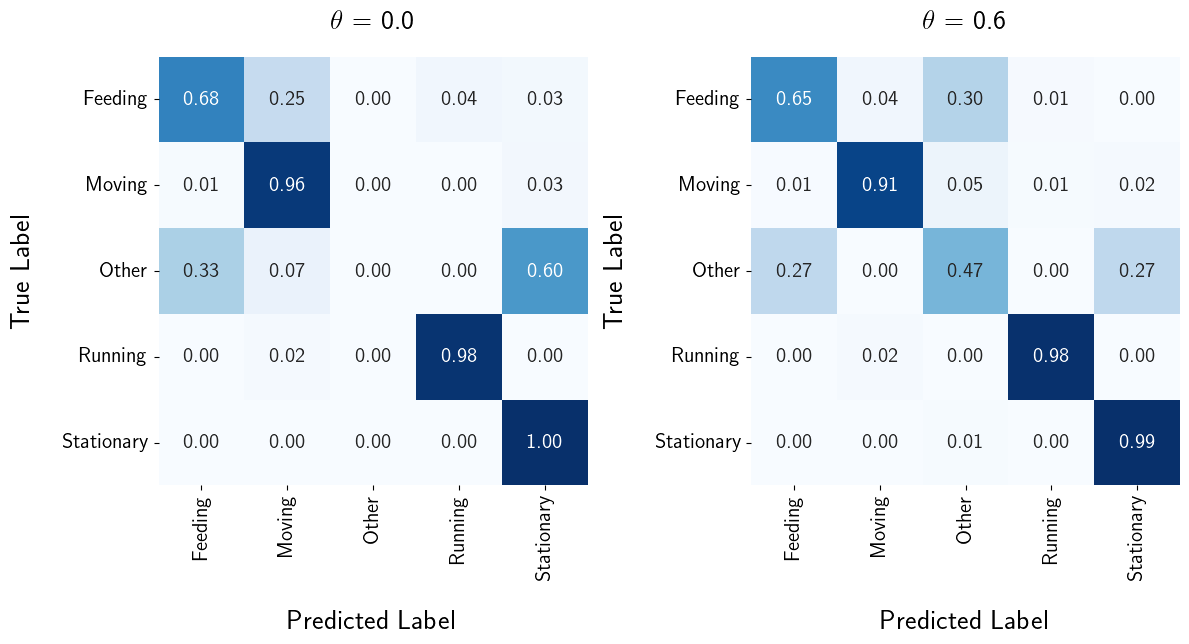

In [14]:
theta_list = [0.0, 0.6]
seed_star = 1
fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 8))

for i, theta in enumerate(theta_list):

    ax = axs[i]

    model_dir = os.path.join(training_results_dir, f"theta{theta}_seed{seed_star}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')
    class_names = label_encoder.inverse_transform(np.arange(len(np.unique(val_true))))

    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, square=True, linewidths=0,
                annot_kws={"size": 15}, ax=ax)

    ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
    ax.set_ylabel("True Label", fontsize=20, labelpad=20)
    ax.set_xticklabels(class_names, fontsize=15, rotation=90)
    ax.set_yticklabels(class_names, fontsize=15, rotation=0)
    ax.set_title(f"$\\theta$ = {theta}", fontsize=20, pad=20)


plt.tight_layout()
plt.show()

In [20]:
with torch.no_grad():
    yt = model(torch.tensor(X_targets[1], dtype=torch.float32).to(device))

yt = yt.cpu().numpy()
yt = np.argmax(yt, axis=1)

print("RVC V3 PREDICTED CLASS DISTRIBUTION")
unique, counts = np.unique(yt, return_counts=True)
proportions = counts / len(yt)

for cls_int, prop in zip(unique, proportions):
    print(f"{label_encoder.inverse_transform([cls_int])[0]}: {prop:.2%}")

RVC V3 PREDICTED CLASS DISTRIBUTION
Feeding: 2.60%
Moving: 10.01%
Other: 10.75%
Running: 5.89%
Stationary: 70.76%


In [13]:
RVC_data = RVC_df[RVC_df.firmware_major_version == 3.0].copy()
RVC_data["behavior"] = label_encoder.inverse_transform(yt)

In [51]:
from src.eval.sightings import make_sightings_plots_from_labels
matched_sightings = pd.read_csv(os.path.join(io.get_data_path(), 'matched_sightings.csv'))

make_sightings_plots_from_labels(matched_sightings,
                                      RVC_data,
                                      verbose=True,
                                      label_name="shallow_coral"
    )

Processing animal-days: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


0